# Dataset Generator:
- Read low level info from slide.
- Extract coordinates from XML.
- Generate patches & masks: ROI-guided + corner augmentation
- Color normalization: macenko-LS & vahadane-LS.
- Background extraction.
- Save CSV. 

In [1]:
from openslide import OpenSlide, lowlevel 
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import numpy as np
from PIL import Image, ImageDraw
import math
from matplotlib import cm
import staintools
import glob

import xml.etree.ElementTree as ET

## Reading low level and the region using OpenSlide

In [2]:
# Define the path for the slides & labels
slides_path = '/Users/gabriel.jimenez/Documents/project/AT8Dataset/AT8_wsi/'
labels_path = '/Users/gabriel.jimenez/Documents/project/AT8Dataset/AT8_XML_annotations/'

######################################################
# TODO: glob from folder to read all slides and xmls #
######################################################
slide_name = 'FAD-APP 717L_P42-06_AT8.ndpi'
label_name = 'FAD-APP 717L_P42-06_AT8.xml'

# Opening the slide image
slide = lowlevel.open(slides_path+slide_name)
keys = lowlevel.get_property_names(slide)
val = lowlevel.get_property_value(slide,keys[-1])

# This are important values for nm -> pixel conversion
offsetX = int(lowlevel.get_property_value(slide, 'hamamatsu.XOffsetFromSlideCentre')) # THIS IS IN NANOMETERS!
offsetY = int(lowlevel.get_property_value(slide, 'hamamatsu.YOffsetFromSlideCentre')) # THIS IS IN NANOMETERS!

resX = float(lowlevel.get_property_value(slide, 'openslide.mpp-x')) # THIS IS IN MICRONS/PIXEL FOR LVL 0!
resY = float(lowlevel.get_property_value(slide, 'openslide.mpp-y')) # THIS IS IN MICRONS/PIXEL FOR LVL 0!

#######################################################################
# TODO: check if all dimensions are in nm (ISSUE: different scanners) #
#######################################################################

In [3]:
slide = OpenSlide(slides_path+slide_name)

# Getting slide level dimentions
slide_levels = slide.level_dimensions

# Printing important information about the current slide
print("[INFO] The slide have ", len(slide_levels), " magnification levels:")
for i in range(len(slide_levels)):
    print(f"   Level {i} (mag x{40/2**i}) with dimensions (in pixels) : {slide_levels[i]}.")

# Chosing the magnification level
slide_dim_lvl = 2

'''
TODO: put a flag because this is just for debugging. We only need to load the ROI to RAM #
'''
# Getting the thumbnail for slide
thm = slide.read_region((0, 0), slide_dim_lvl, slide_levels[slide_dim_lvl])

[INFO] The slide have  9  magnification levels:
   Level 0 (mag x40.0) with dimensions (in pixels) : (119040, 93440).
   Level 1 (mag x20.0) with dimensions (in pixels) : (59520, 46720).
   Level 2 (mag x10.0) with dimensions (in pixels) : (29760, 23360).
   Level 3 (mag x5.0) with dimensions (in pixels) : (14880, 11680).
   Level 4 (mag x2.5) with dimensions (in pixels) : (7440, 5840).
   Level 5 (mag x1.25) with dimensions (in pixels) : (3720, 2920).
   Level 6 (mag x0.625) with dimensions (in pixels) : (1860, 1460).
   Level 7 (mag x0.3125) with dimensions (in pixels) : (930, 730).
   Level 8 (mag x0.15625) with dimensions (in pixels) : (465, 365).


## Extracting coordinates from XML and conversion to pixels

In [4]:
''' 
From nano/micro meters to pixel language :) 
Larger value is X axis (-->)
'''
dimsSlide = np.array(slide_levels[0])*[resX,resY] # this is in micrometers :)
centerPx_X, centerPx_Y = np.array(slide_levels[0])/2
_, factor = np.array(slide_levels[0])/np.array(slide_levels[slide_dim_lvl])

sizeX, sizeY = np.array(slide_levels[0])/factor

# Loading the slide annotations from XML file
tree = ET.parse(labels_path+label_name)
root = tree.getroot()

# Preparing the annotation container
labels = []

# Getting the annotaiton coordinates from the XML file
for boxes in root:
    for obejcts in boxes:
        type_object = int(obejcts.attrib['Type'])
        for vertices in obejcts:
            temp_obj = []
            for vertex in vertices:
                y_mm = float(vertex.attrib['Y']) # this is in milimeters!
                x_mm = float(vertex.attrib['X']) # this is in milimeters!
                y_p_offset = (y_mm)*1000 - (abs(offsetY)/1000) # this is in micrometers!
                x_p_offset = (x_mm)*1000 - (abs(offsetX)/1000) # this is in micrometers!
                y_newCenter = y_p_offset + int(centerPx_Y)*resY # this is in micrometers!
                x_newCenter = x_p_offset + int(centerPx_X)*resX # this is in micrometers!
                y = (y_newCenter/resY)/factor # pixels
                x = (x_newCenter/resX)/factor # pixels

                ''' Flip '''
                y = abs(sizeY - y)
                #x = sizeX - x

                temp_obj.append([round(x), round(y)])
            labels.append([type_object, np.array(temp_obj)])


[INFO] The whole-slide image with the gray matter annotation (dim level 2 )


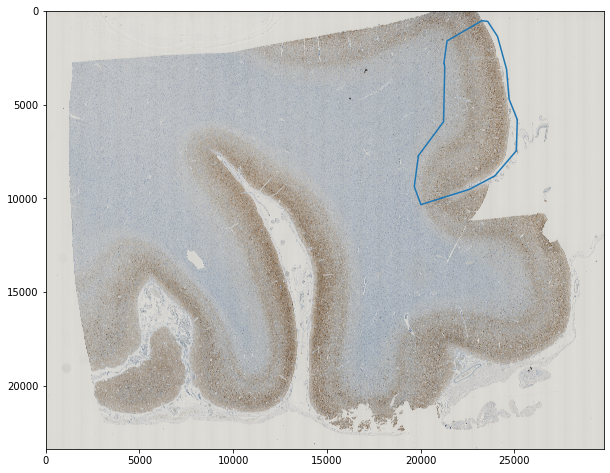

In [5]:
'''
TODO: put a flag because this is just for debugging. We only need to load the ROI to RAM #

'''
# Overlaying the first object (Gray matter annotation)
print("\n[INFO] The whole-slide image with the gray matter annotation (dim level", slide_dim_lvl, ")")
plt.figure(figsize = (10,10))
plt.imshow(thm)
plt.plot(labels[0][1][:, 0], labels[0][1][:, 1])
plt.show()

## Generate patches & masks: ROI-guided.

In [6]:
# Creating a polygone
polygon_patch = Polygon(labels[0][1])

# Getting the bounding box of the label
coords_region = list(polygon_patch.bounds)

# Getting the size of the label
size = (int(coords_region[2]-coords_region[0])+1, int(coords_region[3]-coords_region[1])+1)

# Extracting the region of the label from the whole-slide-image
# region = slide.read_region((int(coords_region[0]*factor), int(coords_region[1]*factor)), slide_dim_lvl, (size[0], size[1]))

In [7]:
# Creating mask for the WSI
mask_ROI = Image.new('L', (int(sizeX), int(sizeY)), 0)
mask_obj = Image.new('L', (int(sizeX), int(sizeY)), 0)

coords_list = []
for obj, coordinates in labels:
    if obj == 1: # this are the annotations by Lev.
        coordinates2list = coordinates.tolist()
        tuples = [tuple(x) for x in coordinates2list]
        ImageDraw.Draw(mask_ROI).polygon(tuples, outline=1, fill=1)
    
    if obj == 2:
        coordinates2list = coordinates.tolist()
        tuples = [tuple(x) for x in coordinates2list]
        ImageDraw.Draw(mask_obj).polygon(tuples, outline=1, fill=1)
        
        polygon_obj = Polygon(coordinates)
        coords_obj = list(polygon_obj.bounds)
        coords_list.append(coords_obj)
        
#mask_ROI_WSI = mask_ROI.crop((coords_region[0],coords_region[1],coords_region[0]+size[0],coords_region[1]+size[1]))
#mask_obj_WSI = mask_obj.crop((coords_region[0],coords_region[1],coords_region[0]+size[0],coords_region[1]+size[1]))

mask_ROI_WSI = mask_ROI.point(lambda i: i * 255)
mask_obj_WSI = mask_obj.point(lambda i: i * 255)

'''
# Save and plot just to check if it is working properly
mask_ROI_WSI.point(lambda i: i * 255).save('./name.png')
mask_obj_WSI.point(lambda i: i * 255).save('./name2.png')

plt.figure()
plt.imshow(mask_ROI_WSI, cmap = "gray")
#plt.xlim((coords_region[0], coords_region[2]))
#plt.ylim((coords_region[3], coords_region[1]))
plt.show()

plt.figure()
plt.imshow(mask_obj_WSI, cmap = "gray")
#plt.xlim((coords_region[0], coords_region[2]))
#plt.ylim((coords_region[3], coords_region[1]))
plt.show()
'''

'\n# Save and plot just to check if it is working properly\nmask_ROI_WSI.point(lambda i: i * 255).save(\'./name.png\')\nmask_obj_WSI.point(lambda i: i * 255).save(\'./name2.png\')\n\nplt.figure()\nplt.imshow(mask_ROI_WSI, cmap = "gray")\n#plt.xlim((coords_region[0], coords_region[2]))\n#plt.ylim((coords_region[3], coords_region[1]))\nplt.show()\n\nplt.figure()\nplt.imshow(mask_obj_WSI, cmap = "gray")\n#plt.xlim((coords_region[0], coords_region[2]))\n#plt.ylim((coords_region[3], coords_region[1]))\nplt.show()\n'

In [8]:
'''
This code creates the region and its corresponding patches for the 4 corners of data augmentation.
'''
patchSize = [128, 128] # [cols, rows]
save_path = "./dataset/128x128/"

# mask_WSI: has all the masks for the annotations and is the same size as the WSI.
# slide: is the original WSI in the level selected. It is not loaded into RAM yet.
# labels: annotations from XML.
# coords_list: list of coordinates of annotated objects.

k = 0
for coords in coords_list: 
    coords[0] = int(math.floor(coords[0]))
    coords[1] = int(math.floor(coords[1]))
    coords[2] = int(math.ceil(coords[2]))
    coords[3] = int(math.ceil(coords[3]))

    size_obj = [coords[2]-coords[0]+1, coords[3]-coords[1]+1]
    new_region_size = np.array(patchSize) - np.array(size_obj)        

    new_coords = (coords[0]-new_region_size[0]/2, coords[1]-new_region_size[1]/2, coords[2]+new_region_size[0]/2, coords[3]+new_region_size[1]/2)        
    new_region_obj = slide.read_region((int(new_coords[0]*factor), int(new_coords[1]*factor)), slide_dim_lvl, (patchSize[0], patchSize[1]))
    new_mask_obj = mask_obj_WSI.crop((int(new_coords[0]),int(new_coords[1]),int(new_coords[0]+patchSize[0]),int(new_coords[1]+patchSize[1])))

    new_region_obj.save(save_path+"patches/patch_"+str(k)+".png")
    new_mask_obj.save(save_path+"masks/mask_"+str(k)+".png")

    '''
    Create 4 additional samples per object/patch ... the annotated object will be in each corner
    '''
    new_region_corner1 = slide.read_region((int(coords[0]*factor), int(coords[1]*factor)), slide_dim_lvl, (patchSize[0], patchSize[1]))
    new_mask_corner1 = mask_obj_WSI.crop((coords[0],coords[1],coords[0]+patchSize[0],coords[1]+patchSize[1]))

    new_region_corner1.save(save_path+"patches/patch_"+str(k)+"_C1"+".png")
    new_mask_corner1.save(save_path+"masks/mask_"+str(k)+"_C1"+".png")

    corner2_coords = (coords[2] - patchSize[0], coords[1])
    new_region_corner2 = slide.read_region((int(corner2_coords[0]*factor), int(corner2_coords[1]*factor)), slide_dim_lvl, (patchSize[0], patchSize[1]))
    new_mask_corner2 = mask_obj_WSI.crop((corner2_coords[0],corner2_coords[1],corner2_coords[0]+patchSize[0],corner2_coords[1]+patchSize[1]))

    new_region_corner2.save(save_path+"patches/patch_"+str(k)+"_C2"+".png")
    new_mask_corner2.save(save_path+"masks/mask_"+str(k)+"_C2"+".png")

    corner3_coords = (coords[2] - patchSize[0], coords[3] - patchSize[1])
    new_region_corner3 = slide.read_region((int(corner3_coords[0]*factor), int(corner3_coords[1]*factor)), slide_dim_lvl, (patchSize[0], patchSize[1]))
    new_mask_corner3 = mask_obj_WSI.crop((corner3_coords[0],corner3_coords[1],corner3_coords[0]+patchSize[0],corner3_coords[1]+patchSize[1]))

    new_region_corner3.save(save_path+"patches/patch_"+str(k)+"_C3"+".png")
    new_mask_corner3.save(save_path+"masks/mask_"+str(k)+"_C3"+".png")

    corner4_coords = (coords[0], coords[3] - patchSize[1])
    new_region_corner4 = slide.read_region((int(corner4_coords[0]*factor), int(corner4_coords[1]*factor)), slide_dim_lvl, (patchSize[0], patchSize[1]))
    new_mask_corner4 = mask_obj_WSI.crop((corner4_coords[0],corner4_coords[1],corner4_coords[0]+patchSize[0],corner4_coords[1]+patchSize[1]))

    new_region_corner4.save(save_path+"patches/patch_"+str(k)+"_C4"+".png")
    new_mask_corner4.save(save_path+"masks/mask_"+str(k)+"_C4"+".png")

    k += 1



FileNotFoundError: [Errno 2] No such file or directory: './dataset/128x128/patches/patch_0.png'

## Color normalization: macenko-LS & vahadane-LS.

In [ ]:
def normalize_alternative(image, ref, method, standartize_brightness):
    if standartize_brightness:
        image = staintools.LuminosityStandardizer.standardize(image)
        ref = staintools.LuminosityStandardizer.standardize(ref)
            
    if method == 'reinhard':
        normalizer = staintools.ReinhardColorNormalizer()
    if method == 'vahadane':
        normalizer = staintools.StainNormalizer(method='vahadane')
    if method == 'macenko':
        normalizer = staintools.StainNormalizer(method='macenko')
            
    normalizer.fit(ref)
    norm_img = normalizer.transform(image)
        
    return norm_img  

In [ ]:
'''
This is taking a lot of time --> paralelize it! --> threads
'''

target = staintools.read_image("./norm_reference_128x128.png")
folder_patches = '/Users/gabriel.jimenez/Documents/project/togitlab/dataset/128x128/patches/'
output_folder_macenko = '/Users/gabriel.jimenez/Documents/project/togitlab/dataset/128x128/macenko/'
output_folder_vahadane = '/Users/gabriel.jimenez/Documents/project/togitlab/dataset/128x128/vahadane/'

for img in glob.glob(folder_patches+'*.png'):
    source = staintools.read_image(img)
    norm_img_macenko = normalize_alternative(source, target, 'macenko', True)
    output_filename_macenko = output_folder_macenko + img.split('/')[-1]
    norm_img_macenko = Image.fromarray(norm_img_macenko)
    norm_img_macenko.save(output_filename_macenko)
    
    norm_img_vahadane = normalize_alternative(source, target, 'vahadane', True)
    output_filename_vahadane = output_folder_vahadane + img.split('/')[-1]
    norm_img_vahadane = Image.fromarray(norm_img_vahadane)
    norm_img_vahadane.save(output_filename_vahadane)

## Background extraction.



In [ ]:
# size of region : cols, rows 
def create_image_patches(img, num_rows, num_columns):
    """
    Partition an image into multiple patches of approximately equal size.
    The patch size is based on the desired number of rows and columns.
    Returns a list of image patches, in row-major order.
    """

    patch_list = []
    width, height = img.shape[1], img.shape[0]
    w, h = width // num_columns, height // num_rows # // is similar to the floor function
    #print(w,h)
    
    for y in range(0, h*num_rows, num_rows): 
        y_end = min(y + num_rows, height)
        for x in range(0, w*num_columns, num_columns):
            x_end = min(x + num_columns, width)
            patch = img[y:y_end, x:x_end]
            patch_list.append(patch)

    return patch_list

In [ ]:
patchSize = 128

background_path = '/Users/gabriel.jimenez/Documents/project/togitlab/dataset/128x128/background/'

mask_ROI_WSI = mask_ROI.crop((coords_region[0],coords_region[1],coords_region[0]+size[0],coords_region[1]+size[1]))
mask_obj_WSI = mask_obj.crop((coords_region[0],coords_region[1],coords_region[0]+size[0],coords_region[1]+size[1]))
region = slide.read_region((int(coords_region[0]*factor), int(coords_region[1]*factor)), slide_dim_lvl, (size[0], size[1]))

mask_ROI_WSI = (np.array(mask_ROI_WSI)>0).astype("uint8")
mask_obj_WSI = (np.array(mask_obj_WSI)>0).astype("uint8")

patch_ROI = create_image_patches(mask_ROI_WSI, patchSize, patchSize)
patch_obj = create_image_patches(mask_obj_WSI, patchSize, patchSize)
patch_region = create_image_patches(np.array(region), patchSize, patchSize)

background_patch = []
save_obj = []
for i in range(len(patch_ROI)):
    pixelSumROI = np.sum(patch_ROI[i])
    if pixelSumROI == patchSize*patchSize:
        pixelSumObj = np.sum(patch_obj[i])
        if pixelSumObj == 0:
            background_patch.append(patch_region[i])
            Image.fromarray(patch_region[i]).save(background_path + 'bg_' + str(i) + '.png')
            #save_obj.append(patch_obj[i])

print(len(background_patch))
    

In [ ]:
plt.figure()
plt.imshow(mask_ROI_WSI)

- Create CSV --> datasetID, WSI_name, WSI_id, CN_id (color normalization), patchID, coords of patch, BOR (background to object ratio)
- patchID --> WSIid_patch_nnnn_cX.npy(png) --> c0: object center, c1: top-left, c2: top-right, c3: bottom-right, c4: bottom-left
- CN_id --> 1: something, CN_id --> 2: else